In [21]:
import torch
import torchinfo
import torch.nn.functional as F
import wandb
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
from sklearn import datasets, decomposition, model_selection
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [22]:
torch.backends.cudnn.deterministic = True
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [23]:
df = pd.read_csv('nba_2022-23_stats.csv')


In [24]:
#see if column types match expected types
print(df.dtypes)


Unnamed: 0         int64
Player Name       object
Salary             int64
Position          object
Age                int64
Team              object
GP                 int64
GS                 int64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P                object
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA              float64
FT%              float64
ORB              float64
DRB              float64
TRB              float64
AST              float64
STL              float64
BLK              float64
TOV              float64
PF               float64
PTS              float64
Total Minutes      int64
PER              float64
TS%              float64
3PAr             float64
FTr              float64
ORB%             float64
DRB%             float64
TRB%             float64
AST%             float64


## Question 1

In [25]:
df_copy = df.copy()

#find row with non numeric value
mask = pd.to_numeric(df_copy['3P'], errors='coerce').isna()
#recalculate value based on the other two columns
df_copy.loc[mask, '3P'] = (df_copy.loc[mask, '3PA'] * df_copy.loc[mask, '3P%']).round(1)
df_copy['3P'] = pd.to_numeric(df_copy['3P'], errors='coerce')

#replace NaN values with 0
df_copy = df_copy.fillna(0)

print(df_copy.dtypes)


Unnamed: 0         int64
Player Name       object
Salary             int64
Position          object
Age                int64
Team              object
GP                 int64
GS                 int64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P               float64
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA              float64
FT%              float64
ORB              float64
DRB              float64
TRB              float64
AST              float64
STL              float64
BLK              float64
TOV              float64
PF               float64
PTS              float64
Total Minutes      int64
PER              float64
TS%              float64
3PAr             float64
FTr              float64
ORB%             float64
DRB%             float64
TRB%             float64
AST%             float64


# Question 2

## Dataset loader

In [26]:
class CSVDataset(Dataset):
	def __init__(self, data, categorical_columns=None, target_columns=None):
		self.data = data
		if(categorical_columns!=None):
			dummies = pd.get_dummies(self.data[categorical_columns], columns=categorical_columns)
			self.data = pd.concat([self.data, dummies], axis=1)
		
		if target_columns is None:
			self.target_columns = self.data.columns
		else:
			self.target_columns = target_columns
		
		# Normalize the data
		self.scaler = MinMaxScaler()
		self.normalized_data = self.scaler.fit_transform(self.data[self.target_columns])

	def __len__(self):
		return len(self.normalized_data)

	def __getitem__(self, idx):
		x = torch.FloatTensor(self.normalized_data[idx])
		return x


In [27]:
full_dataset = CSVDataset(df_copy, categorical_columns=None, target_columns=df_copy.columns[6:])
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

train_data, split = model_selection.train_test_split(full_dataset, test_size=0.2)
valid_data, test_data = model_selection.train_test_split(split, test_size=0.5)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


## Autoencoder

In [28]:
class Autoencoder(nn.Module):
	def __init__(self, input_dim, encoded_dim):
		super(Autoencoder, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			nn.Linear(16, 8),
			nn.ReLU(),
			nn.Linear(8, encoded_dim),
			# nn.ReLU()
		)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 8),
			nn.ReLU(),
			nn.Linear(8, 16),
			nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


## Autoencoder + other dimensionality reduction methods

In [29]:
class Autoencoder_plus(nn.Module):
	def __init__(self, input_dim, encoded_dim):
		super(Autoencoder_plus, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			# nn.Linear(16, 8),
			# nn.ReLU(),
			nn.Linear(16, encoded_dim),
			# nn.ReLU()
		)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 16),
			nn.ReLU(),
			# nn.Linear(8, 16),
			# nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


## Variational Autoencoder

In [30]:
class VariationalAutoencoder(nn.Module):
	def __init__(self, input_dim, encoded_dim=2):
		super(VariationalAutoencoder, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			nn.Linear(16, 8),
			nn.ReLU()
		)

		self.fc_mu = nn.Linear(8, encoded_dim)
		self.fc_logvar = nn.Linear(8, encoded_dim)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 8),
			nn.ReLU(),
			nn.Linear(8, 16),
			nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def encode(self, x):
		hidden = self.encoder(x)
		mu = self.fc_mu(hidden)
		logvar = self.fc_logvar(hidden)
		return mu, logvar

	def reparameterize(self, mu, log_var):
		# if self.training:
		std = torch.exp(0.5 * log_var)
		eps = torch.randn_like(std)
		return mu + eps * std
		# return mu

	def forward(self, x):
		mu, log_var = self.encode(x)
		z = self.reparameterize(mu, log_var)
		decoded = self.decoder(z)
		return decoded, mu, log_var

	def vae_loss(self, recon_x, x, mu, log_var):
		mse_loss = nn.MSELoss(reduction='mean')
		MSE = mse_loss(recon_x, x)
		KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
		
		return MSE + KLD


## Training Loop

In [31]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 2
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder")
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# torchinfo.summary(model, (1, input_dim), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0
	
	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, inputs)
		loss.backward()
		optimizer.step()
		
		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs = model(val_inputs)
			val_loss = criterion(val_outputs, val_inputs)
			total_val_loss += val_loss.item()
		
	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)
	
	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'autoencoder_model.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Validation Loss: {total_val_loss:.4f}')


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▁▁▁▁▁▁▁
epoch,9
train_loss,0.02953
val_loss,0.03635


Epoch [1/100], Train Loss: 0.0603, Validation Loss: 0.0478
Epoch [2/100], Train Loss: 0.0319, Validation Loss: 0.0361
Epoch [3/100], Train Loss: 0.0290, Validation Loss: 0.0353
Epoch [4/100], Train Loss: 0.0255, Validation Loss: 0.0260
Epoch [5/100], Train Loss: 0.0215, Validation Loss: 0.0230
Epoch [6/100], Train Loss: 0.0172, Validation Loss: 0.0186
Epoch [7/100], Train Loss: 0.0151, Validation Loss: 0.0147
Epoch [8/100], Train Loss: 0.0142, Validation Loss: 0.0147
Epoch [9/100], Train Loss: 0.0137, Validation Loss: 0.0140
Epoch [10/100], Train Loss: 0.0139, Validation Loss: 0.0137
Epoch [11/100], Train Loss: 0.0135, Validation Loss: 0.0138
Epoch [12/100], Train Loss: 0.0132, Validation Loss: 0.0136
Epoch [13/100], Train Loss: 0.0129, Validation Loss: 0.0137
Epoch [14/100], Train Loss: 0.0131, Validation Loss: 0.0134
Epoch [15/100], Train Loss: 0.0125, Validation Loss: 0.0130
Epoch [16/100], Train Loss: 0.0124, Validation Loss: 0.0128
Epoch [17/100], Train Loss: 0.0124, Validation Lo

### Auto Encoder Results


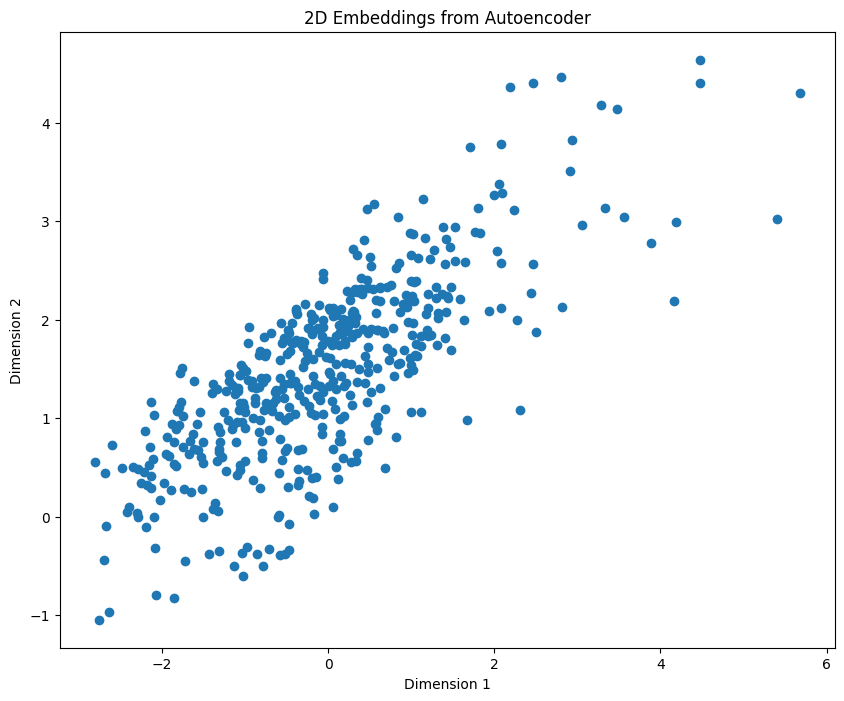

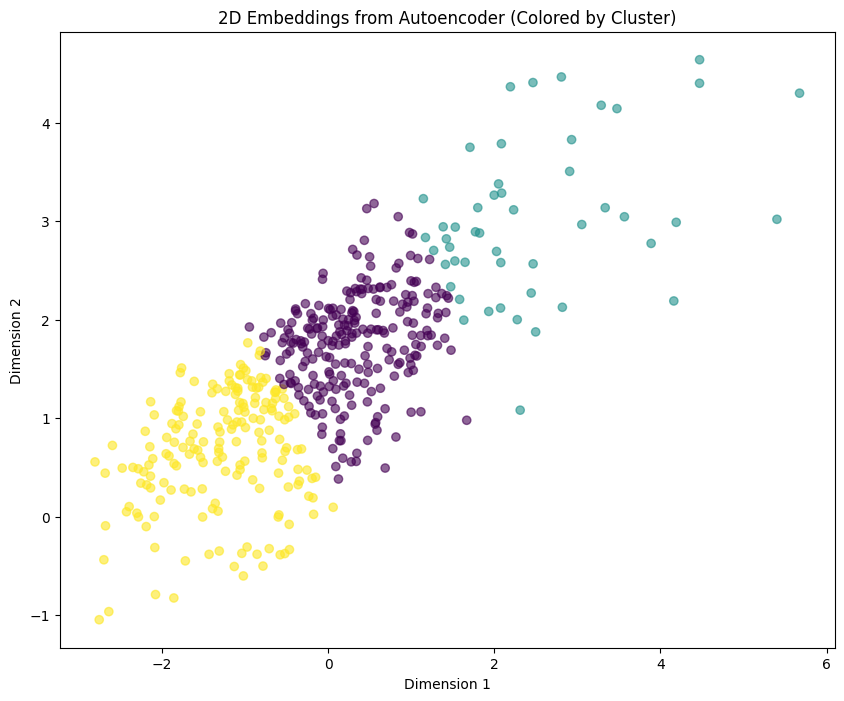

In [32]:
model.eval()
embeddings = []
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		encoded_data = model.encoder(inputs)
		embeddings.append(encoded_data.cpu())

embeddings = torch.cat(embeddings, dim=0)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()


In [33]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 10
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder_plus(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder", name='autoencoder_plus')
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# torchinfo.summary(model, (1, input_dim), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0
	
	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, inputs)
		loss.backward()
		optimizer.step()
		
		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs = model(val_inputs)
			val_loss = criterion(val_outputs, val_inputs)
			total_val_loss += val_loss.item()
		
	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)
	
	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'autoencoder_plus_model.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Validation Loss: {total_val_loss:.4f}')


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00813
val_loss,0.00737


Epoch [1/10], Train Loss: 0.0577, Validation Loss: 0.0434
Epoch [2/10], Train Loss: 0.0309, Validation Loss: 0.0367
Epoch [3/10], Train Loss: 0.0279, Validation Loss: 0.0324
Epoch [4/10], Train Loss: 0.0231, Validation Loss: 0.0227
Epoch [5/10], Train Loss: 0.0175, Validation Loss: 0.0171
Epoch [6/10], Train Loss: 0.0151, Validation Loss: 0.0149
Epoch [7/10], Train Loss: 0.0142, Validation Loss: 0.0143
Epoch [8/10], Train Loss: 0.0138, Validation Loss: 0.0139
Epoch [9/10], Train Loss: 0.0133, Validation Loss: 0.0134
Epoch [10/10], Train Loss: 0.0131, Validation Loss: 0.0132


In [34]:
model.eval()
embeddings = []
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		encoded_data = model.encoder(inputs)
		embeddings.append(encoded_data.cpu())

embeddings = torch.cat(embeddings, dim=0)


### TSNE Results


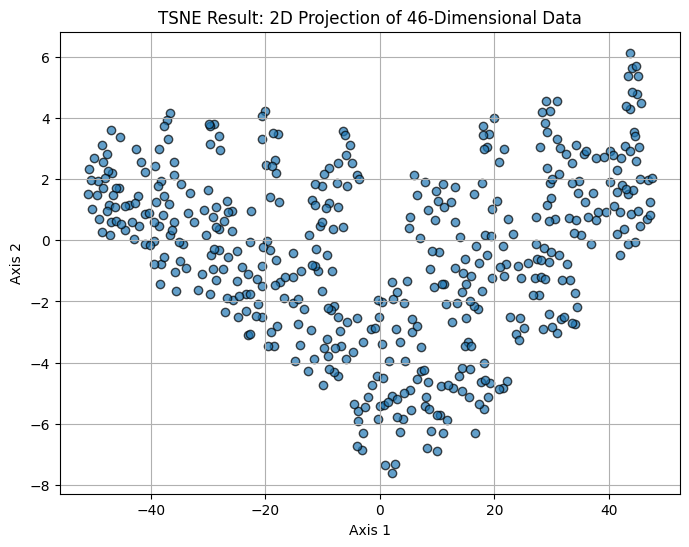

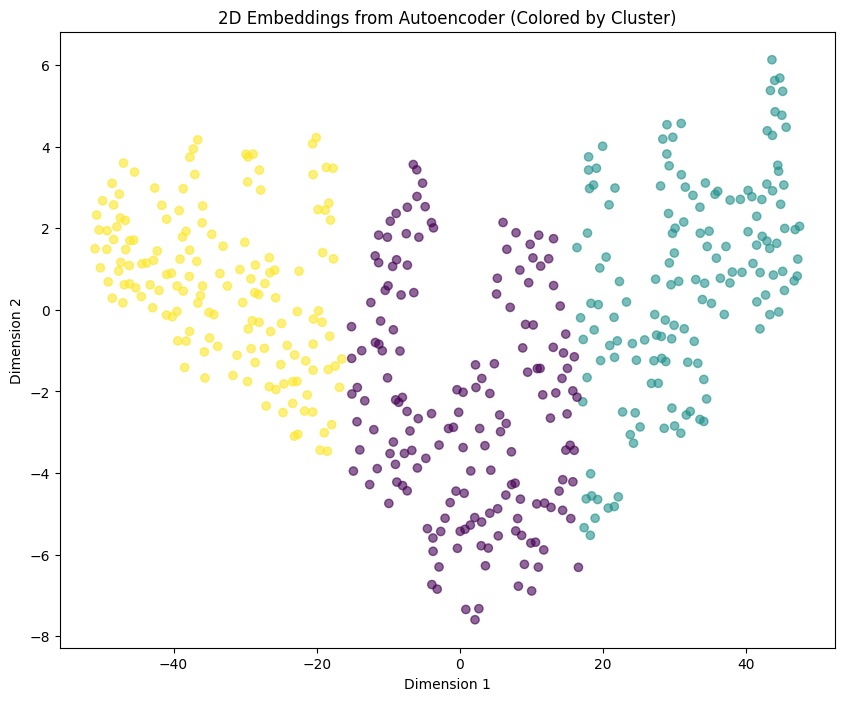

In [35]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, edgecolors='k')
plt.title('TSNE Result: 2D Projection of 46-Dimensional Data')
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(tsne_result)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()


### UMap Results

c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


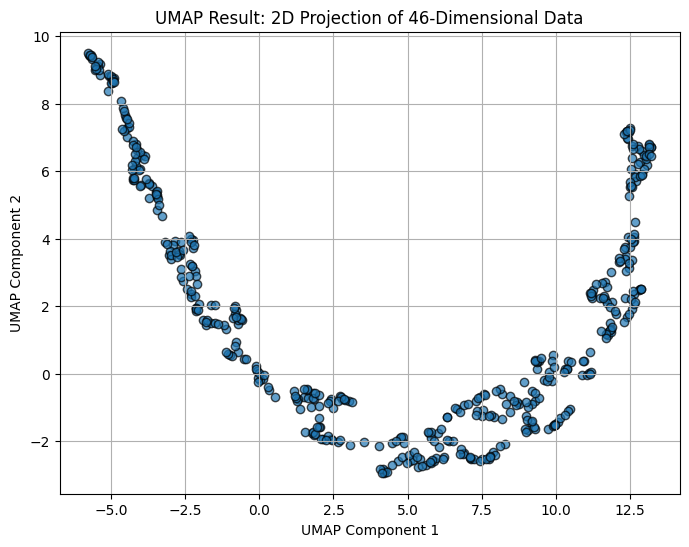

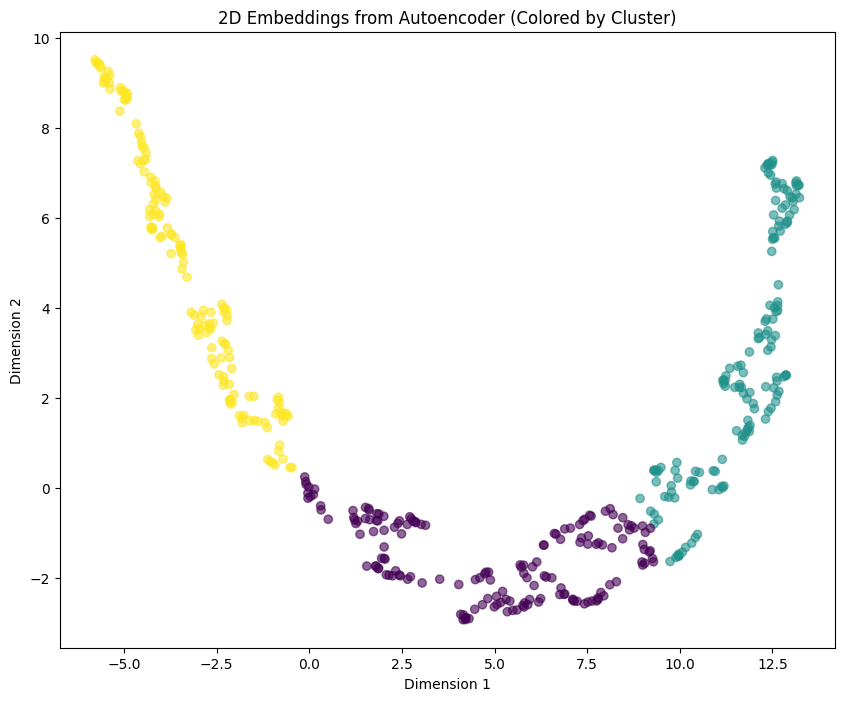

In [36]:
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.7, edgecolors='k')
plt.title('UMAP Result: 2D Projection of 46-Dimensional Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(umap_result)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()


### SOMs Results

torch.Size([467, 10])
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.1504798405589136


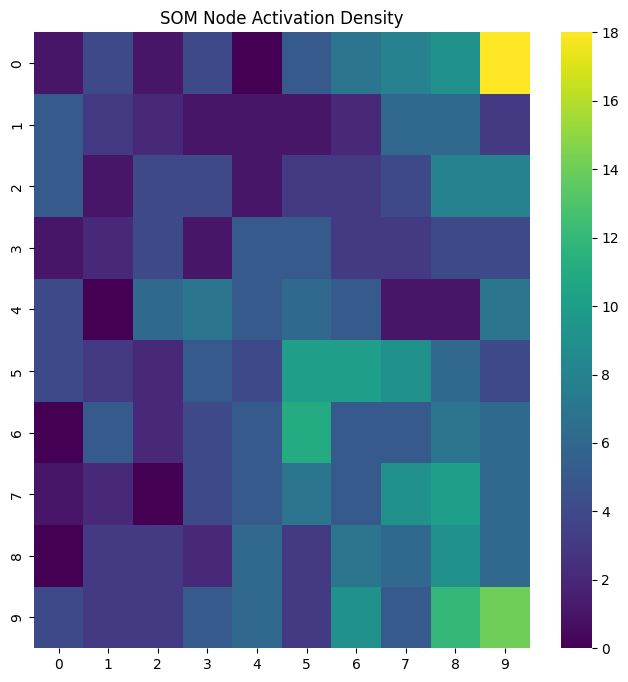

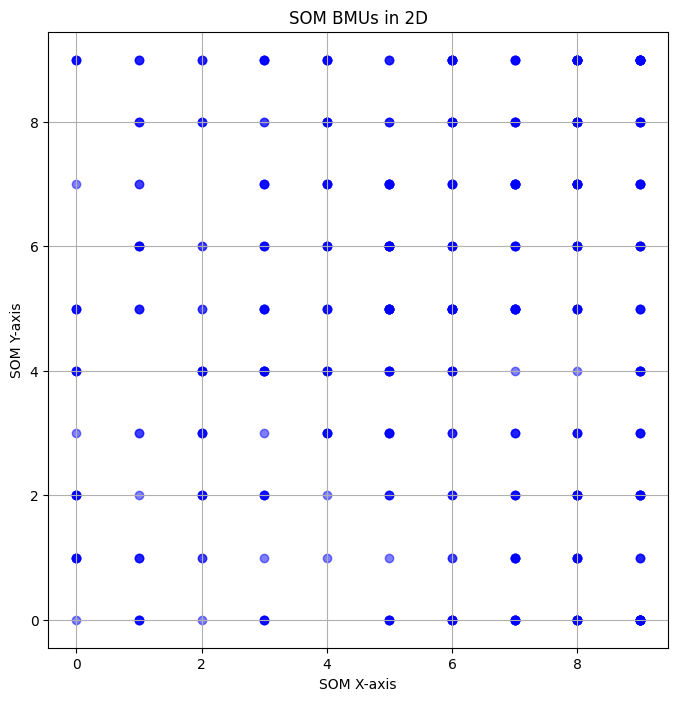

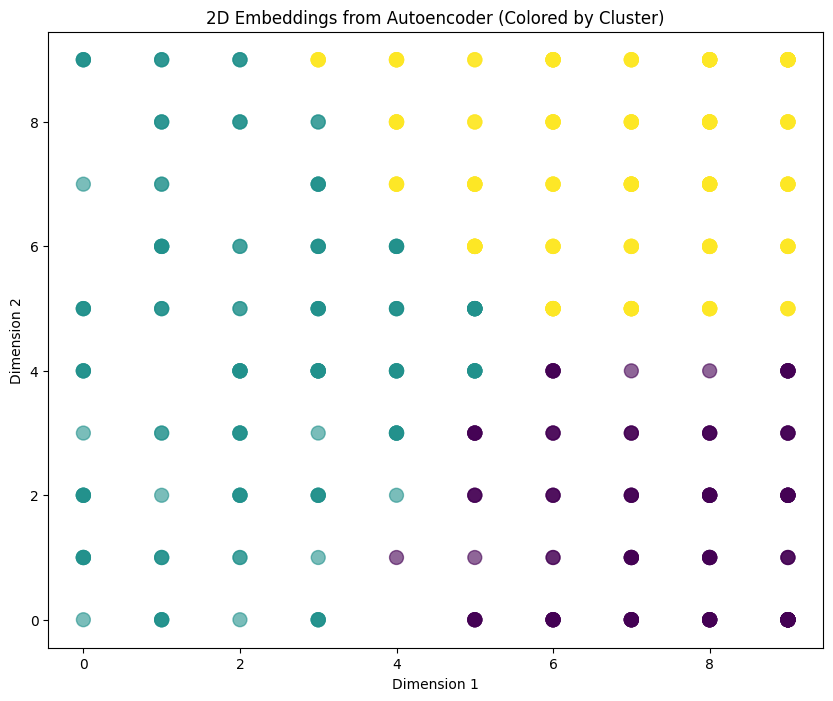

In [41]:
som = MiniSom(x=10,
			  y=10,
			  input_len=embeddings.shape[1],
			  sigma=10/4,
			  learning_rate=0.3,
			  neighborhood_function='gaussian',
			  random_seed=42)

print(embeddings.shape)

som.random_weights_init(embeddings)
som.train(embeddings, 1000, verbose=True)
bmus = np.array([som.winner(x) for x in embeddings])

heatmap = np.zeros((10, 10))
for x, y in bmus:
	heatmap[x, y] += 1

plt.figure(figsize=(8, 8))
sns.heatmap(heatmap.T, cmap='viridis')
plt.title('SOM Node Activation Density')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(bmus[:, 0], bmus[:, 1], c='blue', alpha=0.5)
plt.title('SOM BMUs in 2D')
plt.xlabel('SOM X-axis')
plt.ylabel('SOM Y-axis')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(bmus)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(bmus[:, 0], bmus[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=100)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()


In [38]:
# each neuron represents a cluster
bmus = np.array([som.winner(x) for x in embeddings])


### Variational Autoencoder Results

In [39]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 2
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VariationalAutoencoder(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder", name='variational_autoencoder')
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0

	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs, mu, log_var = model(inputs)
		loss = model.vae_loss(outputs, inputs, mu, log_var)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs, val_mu, val_logvar = model(val_inputs)
			val_loss = model.vae_loss(val_outputs, val_inputs, val_mu, val_logvar)
			total_val_loss += val_loss.item()

	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)

	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'variational_autoencoder.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}')


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▁▁▁▁▁
val_loss,█▆▅▃▂▁▁▁▁▁
epoch,9
train_loss,0.01308
val_loss,0.01321


Epoch [1/10], Train Loss: 0.6397
Epoch [2/10], Train Loss: 0.0539
Epoch [3/10], Train Loss: 0.0456
Epoch [4/10], Train Loss: 0.0314
Epoch [5/10], Train Loss: 0.0314
Epoch [6/10], Train Loss: 0.0302
Epoch [7/10], Train Loss: 0.0298
Epoch [8/10], Train Loss: 0.0295
Epoch [9/10], Train Loss: 0.0298
Epoch [10/10], Train Loss: 0.0295


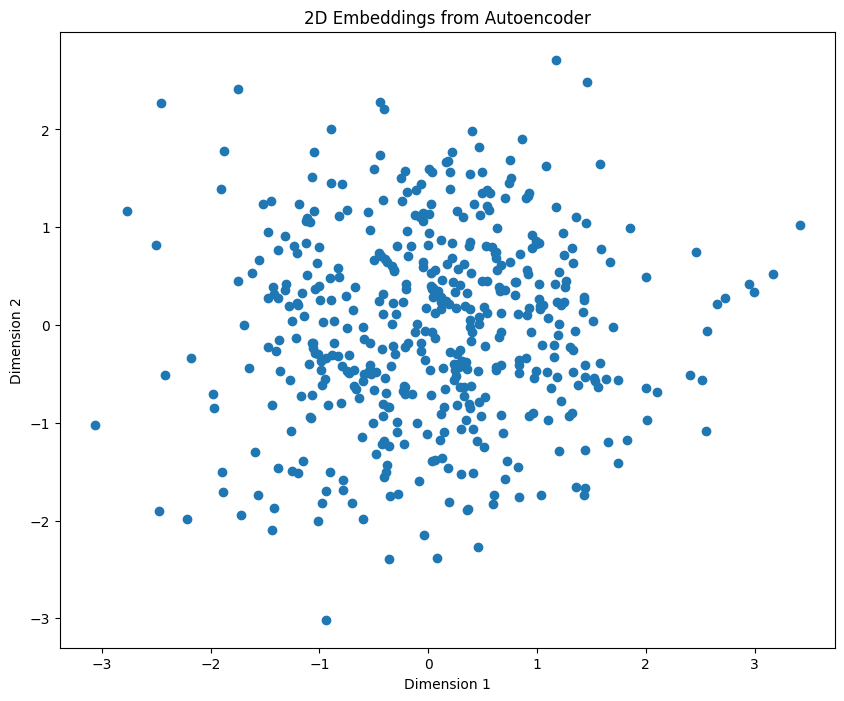

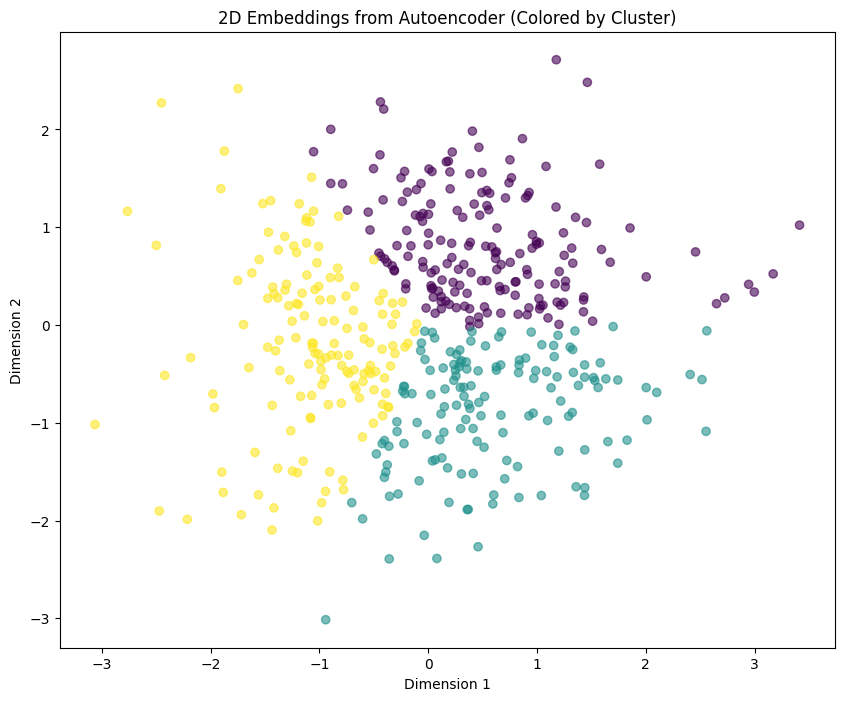

In [40]:
model.eval()
embeddings2 = []
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		mu, log_var = model.encode(inputs)
		z = model.reparameterize(mu, log_var)
		embeddings2.append(z.cpu())

embeddings2 = torch.cat(embeddings2, dim=0)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings2[:, 0], embeddings2[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings2[:, 0], embeddings2[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()
